![../../docs/images/banner-small.png](../../docs/images/banner-small.png)

In [8]:
%matplotlib widget
from IPython.display import clear_output
import numpy as np
from dotenv import load_dotenv
import pygame
import os
import sys
import torch
import cv2
load_dotenv()
if os.environ.get("DEV", False):
    sys.path.append("../..")
else:
    !pip install invertedai
import invertedai as iai
from invertedai import Jupyter_Render, CarlaEnv, CarlaSimulationConfig
clear_output()

Jupyter_Render(children=(HBox(children=(Play(value=0, description='Press play', max=0), IntSlider(value=0, des…

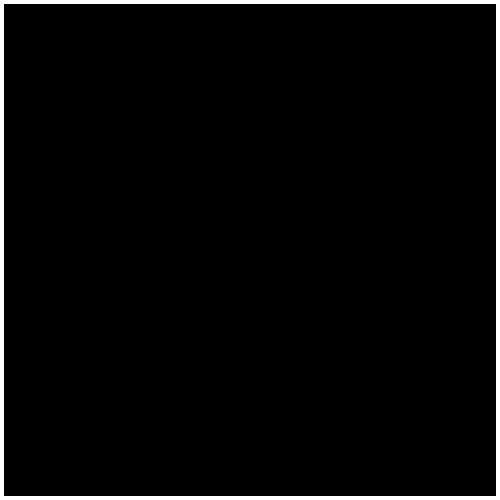

In [16]:
scene_name = "CARLA:Town03:Roundabout"
agent_count = 50
episode_length = 30

carla_cfg = CarlaSimulationConfig(scene_name=scene_name, episode_length=episode_length,
                                 non_roi_npc_mode="spawn_at_entrance",
                                 npc_population_interval=6)
renderer = Jupyter_Render()
display(renderer)

In [17]:
response = iai.initialize(
    location=scene_name,
    agent_count=agent_count,
    fix_carla_coord=True,
)
initial_states = response["states"][0] # Batch Size = 1

sim = CarlaEnv(cfg=carla_cfg, initial_states=initial_states, ego_spawn_point="demo")
# sim = CarlaEnv(cfg=carla_cfg) # Initial states from Carla
states, recurrent_states, dimensions = sim.reset()
clock = pygame.time.Clock()
frames = []

for i in range(carla_cfg.episode_length * carla_cfg.fps):
    response = iai.drive(
        agent_attributes=torch.tensor(dimensions).unsqueeze(0).tolist(),
        states=torch.tensor(states).unsqueeze(0).tolist(),
        recurrent_states=torch.tensor(recurrent_states).unsqueeze(0).tolist(),
        return_birdviews=True,
        location=scene_name,
        obs_length=1,
        step_times=1,
        fix_carla_coord=True,
    )
    states, recurrent_states, dimensions = sim.step(npcs=response, ego="autopilot")

    clock.tick_busy_loop(carla_cfg.fps)
    birdview = cv2.imdecode(np.array(response["bird_view"], dtype=np.uint8), cv2.IMREAD_COLOR)
    renderer.add_frame(birdview)
clear_output()

In [18]:
sim.destroy()